# NBA PLAYER STATS AND PREDICTION

This project focuses on predicting NBA player performance using historical data. The goal is to develop a model that can predict player performance based on various features such as past performance, team statistics, and other relevant factors. The data was sourced from publicly available NBA datasets, which include player stats, game outcomes, and other performance metrics.

### Importing Libraries

In [223]:
import pandas as pd
import requests
import numpy as np
import plotly.express as pex
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import ipywidgets as widgets
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from IPython.display import display
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

### Web Scraping from NBA Website

In this section, data was collected by scraping the NBA website. The dataset includes detailed player statistics for multiple NBA seasons, such as points scored, assists, rebounds, and field goals. Web scraping was done using Python libraries such as requests and BeautifulSoup, and the data was cleaned and formatted for analysis.

In [226]:
static_url='https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=S&Season=2022-23&SeasonType=Regular%20Season&StatCategory=PTS'

In [227]:
def web_scraping():
   
    request_header={
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language' : 'en-US,en;q=0.9',
        'Connection':'keep-alive',
        'Host':'stats.nba.com',
        'Origin':'https://www.nba.com',
        'Referer':'https://www.nba.com/',
        'Sec-Ch-Ua':'"Not A(Brand";v="99", "Microsoft Edge";v="121", "Chromium";v="121"',
        'Sec-Ch-Ua-Mobile':'?0',
        'Sec-Ch-Ua-Platform':'"Windows"',
        'Sec-Fetch-Dest':'empty',
        'Sec-Fetch-Mode':'cors',
        'Sec-Fetch-Site':'same-site',
        'User-Agent':
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0'
    }
    years = ['2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20','2020-21','2021-22','2022-23', '2023-24','2024-25']
    seasons=['Regular%20Season','Playoffs']

    df=pd.DataFrame()
    for y in years:
        for s in seasons:
            dynamic_url= 'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=S&Season='+y+'&SeasonType='+s+'&StatCategory=PTS'
            response=requests.get(url = dynamic_url, headers=request_header).json()
            df1= pd.DataFrame(response['resultSet']['rowSet'], columns= response['resultSet']['headers'] )
            df2= pd.DataFrame({
                'Year':  [y for i in range(len(df1))], 
                'Season': [s for i in range(len(df1))]
            })
            df3 = pd.concat([df2,df1],axis=1)
            df = pd.concat([df, df3], axis=0)
    return df

In [228]:
data=web_scraping()

C:\Users\himas\AppData\Local\Temp\ipykernel_19544\1004075567.py:34: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



### EDA

In this section, data was collected by scraping the NBA website. The dataset includes detailed player statistics for multiple NBA seasons, such as points scored, assists, rebounds, and field goals. Web scraping was done using Python libraries such as requests and BeautifulSoup, and the data was cleaned and formatted for analysis.

In [231]:
data.head()

,Year,Season,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,2013-14,Regular%20Season,201142,1,Kevin Durant,1610612760,OKC,81,3122,849,1688,0.503,192,491,0.391,703,805,0.873,58,540,598,445,103,59,285,174,2593,2572,1.56,0.36
1,2013-14,Regular%20Season,2546,2,Carmelo Anthony,1610612752,NYK,77,2982,743,1643,0.452,167,415,0.402,459,541,0.848,145,477,622,242,95,51,198,224,2112,1942,1.22,0.48
2,2013-14,Regular%20Season,2544,3,LeBron James,1610612748,MIA,77,2902,767,1353,0.567,116,306,0.379,439,585,0.750,81,452,533,488,121,26,270,126,2089,2255,1.81,0.45
3,2013-14,Regular%20Season,201567,4,Kevin Love,1610612750,MIN,77,2797,650,1421,0.457,190,505,0.376,520,633,0.821,224,739,963,341,59,35,196,136,2010,2328,1.74,0.30
4,2013-14,Regular%20Season,201933,5,Blake Griffin,1610612746,LAC,80,2863,718,1359,0.528,12,44,0.273,482,674,0.715,192,565,757,309,92,51,224,265,1930,2082,1.38,0.41


In [232]:
data.tail()

,Year,Season,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
497,2024-25,Regular%20Season,1630556,491,Kessler Edwards,1610612742,DAL,6,10,0,2,0.0,0,2,0.0,0,0,0.0,0,0,0,0,0,0,1,2,0,-3,0.0,0.0
498,2024-25,Regular%20Season,1630644,491,Mac McClung,1610612753,ORL,1,5,0,0,0.0,0,0,0.0,0,0,0.0,0,1,1,2,0,0,0,0,0,3,0.0,0.0
499,2024-25,Regular%20Season,1630222,491,Mason Jones,1610612758,SAC,3,13,0,2,0.0,0,2,0.0,0,0,0.0,1,3,4,7,0,0,0,1,0,9,0.0,0.0
500,2024-25,Regular%20Season,1642434,491,Riley Minix,1610612759,SAS,1,7,0,1,0.0,0,1,0.0,0,0,0.0,0,2,2,0,0,0,0,0,0,1,0.0,0.0
501,2024-25,Regular%20Season,1642461,491,Spencer Jones,1610612743,DEN,2,4,0,1,0.0,0,1,0.0,0,0,0.0,0,1,1,0,2,0,0,0,0,2,0.0,0.0


In [233]:
data.shape

(8660, 30)

In [291]:
def convert_columns_to_float(dataframe,columns_to_convert):
   for col in columns_to_convert:
            dataframe[col] = dataframe[col].astype(float)

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8660 entries, 0 to 501
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       8660 non-null   object 
 1   Season     8660 non-null   object 
 2   PLAYER_ID  8660 non-null   object 
 3   RANK       8660 non-null   object 
 4   PLAYER     8660 non-null   object 
 5   TEAM_ID    8660 non-null   object 
 6   TEAM       8660 non-null   object 
 7   GP         8660 non-null   object 
 8   MIN        8660 non-null   object 
 9   FGM        8660 non-null   object 
 10  FGA        8660 non-null   object 
 11  FG_PCT     8660 non-null   float64
 12  FG3M       8660 non-null   object 
 13  FG3A       8660 non-null   object 
 14  FG3_PCT    8660 non-null   float64
 15  FTM        8660 non-null   object 
 16  FTA        8660 non-null   object 
 17  FT_PCT     8660 non-null   float64
 18  OREB       8660 non-null   object 
 19  DREB       8660 non-null   object 
 20  REB        866

In [236]:
data.describe(include='all')

,Year,Season,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
count,8660,8660,8660.0,8660.0,8660,8.660000e+03,8660,8660.0,8660.0,8660.0,8660.0,8660.000000,8660.0,8660.0,8660.000000,8660.0,8660.0,8660.000000,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.000000,8660.000000
unique,12,2,1576.0,546.0,1576,3.000000e+01,30,84.0,2417.0,690.0,1247.0,NaN,273.0,594.0,NaN,440.0,532.0,NaN,285.0,608.0,750.0,559.0,164.0,175.0,291.0,273.0,1503.0,1639.0,NaN,NaN
top,2021-22,Regular%20Season,201935.0,194.0,James Harden,1.610613e+09,BOS,5.0,6.0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
freq,822,6293,23.0,58.0,23,3.470000e+02,347,403.0,53.0,330.0,131.0,NaN,1778.0,927.0,NaN,890.0,804.0,NaN,808.0,277.0,225.0,567.0,907.0,1463.0,624.0,386.0,265.0,113.0,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.435390,NaN,NaN,0.276819,NaN,NaN,0.674104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.608904,0.635988
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137042,NaN,NaN,0.173921,NaN,NaN,0.265223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.168083,0.564472
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.393000,NaN,NaN,0.190000,NaN,NaN,0.623000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.920000,0.330000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440000,NaN,NaN,0.327000,NaN,NaN,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.480000,0.530000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497000,NaN,NaN,0.377000,NaN,NaN,0.833000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.140000,0.820000


In [237]:
cols_to_convert= ['GP', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL','BLK','TOV','PF','PTS','EFF']
convert_columns_to_float(data,cols_to_convert)

In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8660 entries, 0 to 501
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       8660 non-null   object 
 1   Season     8660 non-null   object 
 2   PLAYER_ID  8660 non-null   object 
 3   RANK       8660 non-null   object 
 4   PLAYER     8660 non-null   object 
 5   TEAM_ID    8660 non-null   object 
 6   TEAM       8660 non-null   object 
 7   GP         8660 non-null   float64
 8   MIN        8660 non-null   float64
 9   FGM        8660 non-null   float64
 10  FGA        8660 non-null   float64
 11  FG_PCT     8660 non-null   float64
 12  FG3M       8660 non-null   float64
 13  FG3A       8660 non-null   float64
 14  FG3_PCT    8660 non-null   float64
 15  FTM        8660 non-null   float64
 16  FTA        8660 non-null   float64
 17  FT_PCT     8660 non-null   float64
 18  OREB       8660 non-null   float64
 19  DREB       8660 non-null   float64
 20  REB        866

In [239]:
data.isna().sum()

Year         0
Season       0
PLAYER_ID    0
RANK         0
PLAYER       0
TEAM_ID      0
TEAM         0
GP           0
MIN          0
FGM          0
FGA          0
FG_PCT       0
FG3M         0
FG3A         0
FG3_PCT      0
FTM          0
FTA          0
FT_PCT       0
OREB         0
DREB         0
REB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
EFF          0
AST_TOV      0
STL_TOV      0
dtype: int64

In [240]:
def modify_data(dataframe):
    dataframe['Season_Start']= dataframe['Year'].str[:4].astype(int)
    dataframe.drop(columns=['RANK','TEAM_ID'], inplace= True)
    dataframe['Season'].replace('Regular%20Season', 'Regular', inplace= True)
    return dataframe

data=modify_data(data)

C:\Users\himas\AppData\Local\Temp\ipykernel_19544\3230527936.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [241]:
data.head()

,Year,Season,PLAYER_ID,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV,Season_Start
0,2013-14,Regular,201142,Kevin Durant,OKC,81.0,3122.0,849.0,1688.0,0.503,192.0,491.0,0.391,703.0,805.0,0.873,58.0,540.0,598,445.0,103.0,59.0,285.0,174.0,2593.0,2572.0,1.56,0.36,2013
1,2013-14,Regular,2546,Carmelo Anthony,NYK,77.0,2982.0,743.0,1643.0,0.452,167.0,415.0,0.402,459.0,541.0,0.848,145.0,477.0,622,242.0,95.0,51.0,198.0,224.0,2112.0,1942.0,1.22,0.48,2013
2,2013-14,Regular,2544,LeBron James,MIA,77.0,2902.0,767.0,1353.0,0.567,116.0,306.0,0.379,439.0,585.0,0.750,81.0,452.0,533,488.0,121.0,26.0,270.0,126.0,2089.0,2255.0,1.81,0.45,2013
3,2013-14,Regular,201567,Kevin Love,MIN,77.0,2797.0,650.0,1421.0,0.457,190.0,505.0,0.376,520.0,633.0,0.821,224.0,739.0,963,341.0,59.0,35.0,196.0,136.0,2010.0,2328.0,1.74,0.30,2013
4,2013-14,Regular,201933,Blake Griffin,LAC,80.0,2863.0,718.0,1359.0,0.528,12.0,44.0,0.273,482.0,674.0,0.715,192.0,565.0,757,309.0,92.0,51.0,224.0,265.0,1930.0,2082.0,1.38,0.41,2013


In [242]:
data.to_excel('nba_stats_data_before_cleaning.xlsx', index=False)

In [243]:
no_of_players = data['PLAYER_ID'].nunique()
no_of_teams=data.TEAM.nunique()
print('The no.of unique players: ',  no_of_players)
print('No.of Teams :', no_of_teams)

The no.of unique players:  1576
No.of Teams : 30


## Data Preprocessing

Modifications were made to the dataset to enhance its usability for analysis. A new column, Season_Start, was added, extracting the starting year of each season from the Year column. Unnecessary columns such as RANK and TEAM_ID were removed, and the 'Season' column was cleaned by replacing 'Regular%20Season' with 'Regular'. This preprocessing step ensures that the dataset is streamlined and ready for further analysis.

In [246]:
tot_cols =['MIN','FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF','PTS']

In [247]:
def group_by_playerID(columns):
    data_per_player = data.groupby(['PLAYER','PLAYER_ID','Year'])[columns].sum().reset_index()
    return data_per_player

In [248]:
data_per_player=group_by_playerID(tot_cols)
data_per_player.head()

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Lawson,1630639,2022-23,108.0,22.0,44.0,0.500,10.0,25.0,0.400,2.0,8.0,0.250,6.0,15.0,21,2.0,2.0,0.0,3.0,11.0,56.0
1,A.J. Lawson,1630639,2023-24,341.0,58.0,130.0,0.890,15.0,56.0,0.593,16.0,25.0,1.152,15.0,38.0,53,20.0,10.0,4.0,14.0,23.0,147.0
2,AJ Green,1631260,2022-23,345.0,53.0,125.0,0.424,44.0,105.0,0.419,4.0,4.0,1.000,6.0,39.0,45,22.0,6.0,0.0,9.0,31.0,154.0
3,AJ Green,1631260,2023-24,681.0,89.0,212.0,0.798,71.0,180.0,0.590,20.0,22.0,1.895,9.0,64.0,73,32.0,9.0,4.0,13.0,58.0,269.0
4,AJ Green,1631260,2024-25,507.0,65.0,136.0,0.478,59.0,124.0,0.476,5.0,6.0,0.833,4.0,47.0,51,23.0,12.0,2.0,17.0,51.0,194.0


In [249]:

for col in data_per_player.columns[4:] :
    data_per_player[col] = data_per_player[col]/data_per_player['MIN']

data_per_player

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Lawson,1630639,2022-23,108.0,0.203704,0.407407,0.004630,0.092593,0.231481,0.003704,0.018519,0.074074,0.002315,0.055556,0.138889,0.194444,0.018519,0.018519,0.000000,0.027778,0.101852,0.518519
1,A.J. Lawson,1630639,2023-24,341.0,0.170088,0.381232,0.002610,0.043988,0.164223,0.001739,0.046921,0.073314,0.003378,0.043988,0.111437,0.155425,0.058651,0.029326,0.011730,0.041056,0.067449,0.431085
2,AJ Green,1631260,2022-23,345.0,0.153623,0.362319,0.001229,0.127536,0.304348,0.001214,0.011594,0.011594,0.002899,0.017391,0.113043,0.130435,0.063768,0.017391,0.000000,0.026087,0.089855,0.446377
3,AJ Green,1631260,2023-24,681.0,0.130690,0.311307,0.001172,0.104258,0.264317,0.000866,0.029369,0.032305,0.002783,0.013216,0.093979,0.107195,0.046990,0.013216,0.005874,0.019090,0.085169,0.395007
4,AJ Green,1631260,2024-25,507.0,0.128205,0.268245,0.000943,0.116371,0.244576,0.000939,0.009862,0.011834,0.001643,0.007890,0.092702,0.100592,0.045365,0.023669,0.003945,0.033531,0.100592,0.382643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,Zion Williamson,1629627,2023-24,2207.0,0.282737,0.495696,0.000258,0.002719,0.008156,0.000151,0.157227,0.223833,0.000318,0.055279,0.128681,0.18396,0.159493,0.034889,0.021296,0.087449,0.072043,0.725419
6296,Zion Williamson,1629627,2024-25,186.0,0.252688,0.559140,0.002430,0.010753,0.032258,0.001790,0.215054,0.322581,0.003586,0.086022,0.172043,0.258065,0.172043,0.021505,0.037634,0.118280,0.096774,0.731183
6297,Zoran Dragic,204054,2014-15,75.0,0.146667,0.400000,0.004893,0.040000,0.186667,0.002853,0.040000,0.066667,0.008000,0.066667,0.040000,0.106667,0.066667,0.026667,0.000000,0.066667,0.080000,0.373333
6298,Zylan Cheatham,1629597,2019-20,51.0,0.117647,0.176471,0.013078,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.058824,0.117647,0.176471,0.058824,0.019608,0.019608,0.078431,0.196078,0.235294


In [250]:
data_per_player=data_per_player[data_per_player['MIN']>=100]
data_per_player

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Lawson,1630639,2022-23,108.0,0.203704,0.407407,0.004630,0.092593,0.231481,0.003704,0.018519,0.074074,0.002315,0.055556,0.138889,0.194444,0.018519,0.018519,0.000000,0.027778,0.101852,0.518519
1,A.J. Lawson,1630639,2023-24,341.0,0.170088,0.381232,0.002610,0.043988,0.164223,0.001739,0.046921,0.073314,0.003378,0.043988,0.111437,0.155425,0.058651,0.029326,0.011730,0.041056,0.067449,0.431085
2,AJ Green,1631260,2022-23,345.0,0.153623,0.362319,0.001229,0.127536,0.304348,0.001214,0.011594,0.011594,0.002899,0.017391,0.113043,0.130435,0.063768,0.017391,0.000000,0.026087,0.089855,0.446377
3,AJ Green,1631260,2023-24,681.0,0.130690,0.311307,0.001172,0.104258,0.264317,0.000866,0.029369,0.032305,0.002783,0.013216,0.093979,0.107195,0.046990,0.013216,0.005874,0.019090,0.085169,0.395007
4,AJ Green,1631260,2024-25,507.0,0.128205,0.268245,0.000943,0.116371,0.244576,0.000939,0.009862,0.011834,0.001643,0.007890,0.092702,0.100592,0.045365,0.023669,0.003945,0.033531,0.100592,0.382643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6292,Zion Williamson,1629627,2019-20,668.0,0.314371,0.538922,0.000873,0.008982,0.020958,0.000642,0.170659,0.266467,0.000958,0.095808,0.128743,0.224551,0.074850,0.023952,0.013473,0.088323,0.062874,0.808383
6293,Zion Williamson,1629627,2020-21,2026.0,0.312932,0.511846,0.000302,0.004936,0.016782,0.000145,0.182132,0.261106,0.000345,0.082428,0.135242,0.21767,0.111550,0.028134,0.019250,0.082428,0.066634,0.812932
6294,Zion Williamson,1629627,2022-23,956.0,0.298117,0.490586,0.000636,0.007322,0.019874,0.000385,0.185146,0.259414,0.000747,0.060669,0.150628,0.211297,0.139121,0.033473,0.016736,0.103556,0.067992,0.788703
6295,Zion Williamson,1629627,2023-24,2207.0,0.282737,0.495696,0.000258,0.002719,0.008156,0.000151,0.157227,0.223833,0.000318,0.055279,0.128681,0.18396,0.159493,0.034889,0.021296,0.087449,0.072043,0.725419


In [251]:
data_per_player.shape

(5423, 22)

### Feature Engineering

Key ratios like PTS/FGA, FG3M/FGM, FTA/FGA, 3PT%, and FT% were calculated to measure scoring efficiency. A correlation matrix was used to identify features most related to True Shooting Percentage (TRU%). The top correlated features selected for prediction were FTA/FGA, PTS, FGM, FG%, and PTS/FGA. A heatmap visualization helped highlight these relationships.

In [254]:
data_per_player['FG%'] = data_per_player['FGM']/data_per_player['FGA']
data_per_player['3PT%'] = data_per_player['FG3M']/data_per_player['FG3A']
data_per_player['FT%'] = data_per_player['FTM']/data_per_player['FTA']
#proportion of a player's field goal attempts that come from three-point range compared to their total field goal attempts
data_per_player['FG3A%'] = data_per_player['FG3A']/data_per_player['FGA']
#number of points scored per field goal attempt
data_per_player['PTS/FGA'] = data_per_player['PTS']/data_per_player['FGA']
# proportion of a player's field goals made that come from three-point range compared to their total field goals made
data_per_player['FG3M/FGM'] = data_per_player['FG3M']/data_per_player['FGM']
# proportion of a player's field goal attempts that result in free throw attempts
data_per_player['FTA/FGA'] = data_per_player['FTA']/data_per_player['FGA']
#True shooting percentages
data_per_player['TRU%'] = 0.5*data_per_player['PTS']/(data_per_player['FGA']+0.475*data_per_player['FTA'])
#assist-to-turnover ratio for a player
data_per_player['AST_TOV'] = data_per_player['AST']/data_per_player['TOV']

data_per_player

C:\Users\himas\AppData\Local\Temp\ipykernel_19544\1980559105.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\himas\AppData\Local\Temp\ipykernel_19544\1980559105.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\himas\AppData\Local\Temp\ipykernel_19544\1980559105.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,FG%,3PT%,FT%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST_TOV
0,A.J. Lawson,1630639,2022-23,108.0,0.203704,0.407407,0.004630,0.092593,0.231481,0.003704,0.018519,0.074074,0.002315,0.055556,0.138889,0.194444,0.018519,0.018519,0.000000,0.027778,0.101852,0.518519,0.500000,0.400000,0.250000,0.568182,1.272727,0.454545,0.181818,0.585774,0.666667
1,A.J. Lawson,1630639,2023-24,341.0,0.170088,0.381232,0.002610,0.043988,0.164223,0.001739,0.046921,0.073314,0.003378,0.043988,0.111437,0.155425,0.058651,0.029326,0.011730,0.041056,0.067449,0.431085,0.446154,0.267857,0.640000,0.430769,1.130769,0.258621,0.192308,0.518062,1.428571
2,AJ Green,1631260,2022-23,345.0,0.153623,0.362319,0.001229,0.127536,0.304348,0.001214,0.011594,0.011594,0.002899,0.017391,0.113043,0.130435,0.063768,0.017391,0.000000,0.026087,0.089855,0.446377,0.424000,0.419048,1.000000,0.840000,1.232000,0.830189,0.032000,0.606777,2.444444
3,AJ Green,1631260,2023-24,681.0,0.130690,0.311307,0.001172,0.104258,0.264317,0.000866,0.029369,0.032305,0.002783,0.013216,0.093979,0.107195,0.046990,0.013216,0.005874,0.019090,0.085169,0.395007,0.419811,0.394444,0.909091,0.849057,1.268868,0.797753,0.103774,0.604630,2.461538
4,AJ Green,1631260,2024-25,507.0,0.128205,0.268245,0.000943,0.116371,0.244576,0.000939,0.009862,0.011834,0.001643,0.007890,0.092702,0.100592,0.045365,0.023669,0.003945,0.033531,0.100592,0.382643,0.477941,0.475806,0.833333,0.911765,1.426471,0.907692,0.044118,0.698596,1.352941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6292,Zion Williamson,1629627,2019-20,668.0,0.314371,0.538922,0.000873,0.008982,0.020958,0.000642,0.170659,0.266467,0.000958,0.095808,0.128743,0.224551,0.074850,0.023952,0.013473,0.088323,0.062874,0.808383,0.583333,0.428571,0.640449,0.038889,1.500000,0.028571,0.494444,0.607356,0.847458
6293,Zion Williamson,1629627,2020-21,2026.0,0.312932,0.511846,0.000302,0.004936,0.016782,0.000145,0.182132,0.261106,0.000345,0.082428,0.135242,0.21767,0.111550,0.028134,0.019250,0.082428,0.066634,0.812932,0.611379,0.294118,0.697543,0.032787,1.588235,0.015773,0.510125,0.639227,1.353293
6294,Zion Williamson,1629627,2022-23,956.0,0.298117,0.490586,0.000636,0.007322,0.019874,0.000385,0.185146,0.259414,0.000747,0.060669,0.150628,0.211297,0.139121,0.033473,0.016736,0.103556,0.067992,0.788703,0.607676,0.368421,0.713710,0.040512,1.607676,0.024561,0.528785,0.642468,1.343434
6295,Zion Williamson,1629627,2023-24,2207.0,0.282737,0.495696,0.000258,0.002719,0.008156,0.000151,0.157227,0.223833,0.000318,0.055279,0.128681,0.18396,0.159493,0.034889,0.021296,0.087449,0.072043,0.725419,0.570384,0.333333,0.702429,0.016453,1.463437,0.009615,0.451554,0.602491,1.823834


In [255]:
cols_for_correlation = ['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TOV','PF','PTS','FG%','3PT%','FT%','FG3A%','PTS/FGA','FG3M/FGM','FTA/FGA','TRU%','AST_TOV']
correlation=data_per_player[cols_for_correlation].corr()

fig = pex.imshow(correlation)
fig.update_layout(
    height=600,
    width=600    
)
fig.show()

In [256]:
correlation['TRU%'].sort_values()

FT_PCT     -0.185266
STL        -0.116243
FG3_PCT    -0.114050
FG3A%      -0.113568
AST_TOV    -0.096094
AST        -0.093325
FG3M/FGM   -0.062555
FG3A       -0.058728
TOV        -0.056526
FG_PCT     -0.049531
PF          0.000323
FGA         0.027103
FG3M        0.104154
FT%         0.174800
FTA         0.246145
OREB        0.248797
3PT%        0.250247
BLK         0.255303
DREB        0.261817
FTM         0.267080
REB         0.278374
FTA/FGA     0.282429
PTS         0.383646
FGM         0.389669
FG%         0.805323
PTS/FGA     0.914488
TRU%        1.000000
Name: TRU%, dtype: float64

selecting the features with highest correction. Here to predict True Shooting percentage I chose FTA/FGA, PTS, FGM, FG%, PTS/FGA

### Model Selection, Training and Evaluation

The dataset is prepared for model training using XGBoost. The data is converted into DMatrix format, and an XGBoost model is trained with specified hyperparameters such as learning rate, maximum depth, and number of estimators. The model’s performance is evaluated using regression metrics, showing an R² score of 0.879, a low Mean Squared Error (0.00044), and a low Mean Absolute Error (0.01599), indicating good predictive accuracy. A warning regarding unused parameters is also noted.

In [260]:
features=['PTS','FGM','FG%','PTS/FGA']

In [261]:
X=data_per_player[features]
Y=data_per_player['TRU%']

In [262]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y, test_size=0.3, random_state=42)

In [263]:
dtotal=xgb.DMatrix(X,label=Y)
dtrain=xgb.DMatrix(xtrain,label=ytrain)
dtest=xgb.DMatrix(xtest,label=ytest)

In [453]:


def training_model(learning_rate, max_depth,n_estimators, subsample,child_weight,training_matrix,testing_matrix):
    
    params={
    'objective':'reg:squarederror',
    'learning_rate': learning_rate,
    'max_depth' :max_depth,
    'n_estimators':n_estimators,
    'eval_metrics':'rmse',
    'subsample': subsample,
    'min_child_weight': child_weight
    }
    model=xgb.train(
        params,
        training_matrix,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(testing_matrix,'test')],
    )
    return model

model = training_model(learning_rate=0.1, max_depth=6,n_estimators=100, subsample=0.9,child_weight=1,training_matrix=dtrain,testing_matrix=dtest)

ypred=model.predict(dtest)

def calculate_metrics(y_pred,y_test):

    print(f'R2 score:, {r2_score(y_test, y_pred)}')
    print(f'Mean Squared Error:, {mean_squared_error(y_test, y_pred)}')
    print(f'Mean Absolute Error:, {mean_absolute_error(y_test, y_pred)}')

calculate_metrics(ypred,ytest)
    

[0]	test-rmse:0.05641
[1]	test-rmse:0.05171
[2]	test-rmse:0.04752
[3]	test-rmse:0.04388
[4]	test-rmse:0.04064
[5]	test-rmse:0.03781
[6]	test-rmse:0.03533
[7]	test-rmse:0.03319
[8]	test-rmse:0.03131
[9]	test-rmse:0.02973
[10]	test-rmse:0.02831
[11]	test-rmse:0.02718
[12]	test-rmse:0.02618
[13]	test-rmse:0.02538
[14]	test-rmse:0.02472
[15]	test-rmse:0.02415
[16]	test-rmse:0.02368
[17]	test-rmse:0.02326


D:\Hima\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metrics", "n_estimators" } are not used.




[18]	test-rmse:0.02293
[19]	test-rmse:0.02266
[20]	test-rmse:0.02244
[21]	test-rmse:0.02225
[22]	test-rmse:0.02209
[23]	test-rmse:0.02198
[24]	test-rmse:0.02189
[25]	test-rmse:0.02180
[26]	test-rmse:0.02175
[27]	test-rmse:0.02169
[28]	test-rmse:0.02168
[29]	test-rmse:0.02165
[30]	test-rmse:0.02162
[31]	test-rmse:0.02163
[32]	test-rmse:0.02166
[33]	test-rmse:0.02164
[34]	test-rmse:0.02164
[35]	test-rmse:0.02163
[36]	test-rmse:0.02164
[37]	test-rmse:0.02164
[38]	test-rmse:0.02164
[39]	test-rmse:0.02165
R2 score:, 0.8764023781127173
Mean Squared Error:, 0.0004693913014918361
Mean Absolute Error:, 0.016295003043878015


#### HyperParameter Tuning

Hyperparameter tuning is not explicitly performed, but a prediction model is built using the selected features. The XGBoost model is trained with hyperparameters like learning rate, max depth, n_estimators, subsample, and min_child_weight. The function training_model() trains the model with these parameters, and it uses early stopping based on RMSE (Root Mean Squared Error) to optimize the model’s performance.

The model parameters are set to control the complexity and fitting of the model, such as the depth of trees and the learning rate, to minimize error and improve the generalization of predictions.

In [445]:
def hyper_parameter_tuning(predictors,target,param_grid):
    xgb_regressor = XGBRegressor()
    
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)
    grid_search.fit(predictors, target)
    
    print("Best Parameters:", grid_search.best_params_)



In [447]:
param_grid = {
         'max_depth': [1,3, 5, 7],
        'learning_rate': [0.05,0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5]
    }
hyper_parameter_tuning(xtrain,ytrain,param_grid)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


Choosing the best hyper parameters

In [457]:
model=training_model(learning_rate=0.05, max_depth=5,n_estimators=100, subsample=0.8,child_weight=5,training_matrix=dtrain,testing_matrix=dtest)
y_predict=model.predict(dtest)
calculate_metrics(y_predict,ytest)

[0]	test-rmse:0.05908
[1]	test-rmse:0.05655
[2]	test-rmse:0.05416
[3]	test-rmse:0.05195
[4]	test-rmse:0.04986
[5]	test-rmse:0.04788
[6]	test-rmse:0.04603
[7]	test-rmse:0.04427
[8]	test-rmse:0.04263
[9]	test-rmse:0.04109
[10]	test-rmse:0.03964
[11]	test-rmse:0.03831
[12]	test-rmse:0.03702
[13]	test-rmse:0.03583
[14]	test-rmse:0.03471
[15]	test-rmse:0.03368
[16]	test-rmse:0.03271
[17]	test-rmse:0.03181
[18]	test-rmse:0.03099
[19]	test-rmse:0.03022
[20]	test-rmse:0.02950
[21]	test-rmse:0.02883
[22]	test-rmse:0.02822


D:\Hima\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metrics", "n_estimators" } are not used.




[23]	test-rmse:0.02765
[24]	test-rmse:0.02712
[25]	test-rmse:0.02662
[26]	test-rmse:0.02615
[27]	test-rmse:0.02574
[28]	test-rmse:0.02536
[29]	test-rmse:0.02501
[30]	test-rmse:0.02469
[31]	test-rmse:0.02439
[32]	test-rmse:0.02411
[33]	test-rmse:0.02387
[34]	test-rmse:0.02364
[35]	test-rmse:0.02343
[36]	test-rmse:0.02325
[37]	test-rmse:0.02308
[38]	test-rmse:0.02293
[39]	test-rmse:0.02279
[40]	test-rmse:0.02265
[41]	test-rmse:0.02254
[42]	test-rmse:0.02243
[43]	test-rmse:0.02234
[44]	test-rmse:0.02226
[45]	test-rmse:0.02216
[46]	test-rmse:0.02210
[47]	test-rmse:0.02203
[48]	test-rmse:0.02198
[49]	test-rmse:0.02193
[50]	test-rmse:0.02187
[51]	test-rmse:0.02183
[52]	test-rmse:0.02178
[53]	test-rmse:0.02174
[54]	test-rmse:0.02170
[55]	test-rmse:0.02166
[56]	test-rmse:0.02162
[57]	test-rmse:0.02160
[58]	test-rmse:0.02157
[59]	test-rmse:0.02154
[60]	test-rmse:0.02152
[61]	test-rmse:0.02150
[62]	test-rmse:0.02148
[63]	test-rmse:0.02146
[64]	test-rmse:0.02145
[65]	test-rmse:0.02143
[66]	test-r

### Evaluating Results

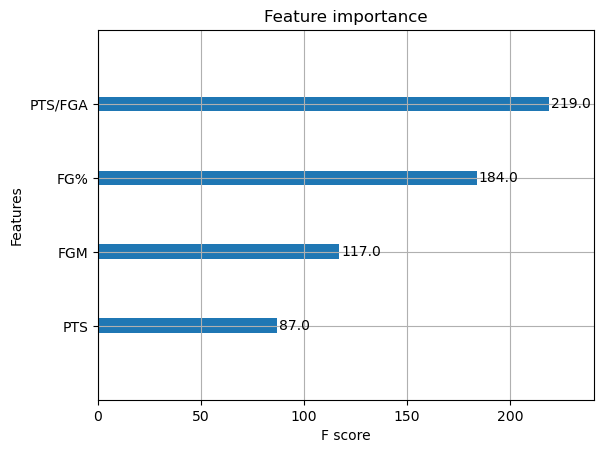

In [271]:
xgb.plot_importance(model)
plt.show()

In [272]:
residuals = ytest - y_predict

# Create an error matrix
error_matrix = np.column_stack((ytest, y_predict, residuals))

# Print the error matrix
print("Error Matrix:")
print(error_matrix)

Error Matrix:
[[ 0.56306208  0.53019977  0.03286232]
 [ 0.51880352  0.5213092  -0.00250567]
 [ 0.56630639  0.53016287  0.03614352]
 ...
 [ 0.5849526   0.54383188  0.04112071]
 [ 0.57851517  0.57787269  0.00064247]
 [ 0.58784921  0.56150514  0.02634407]]


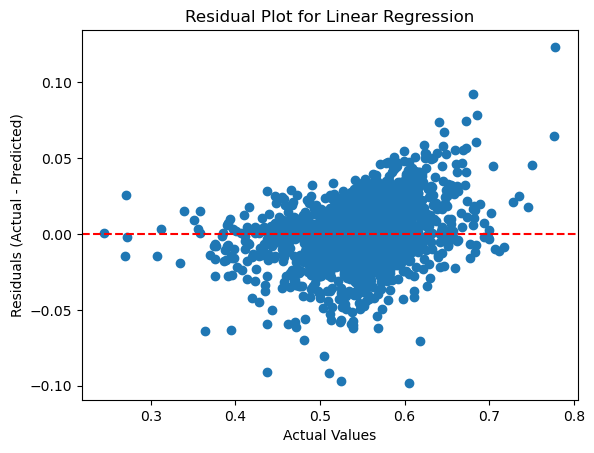

In [273]:
plt.scatter(ytest, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add horizontal line at y=0
plt.xlabel("Actual Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for Linear Regression")
plt.show()

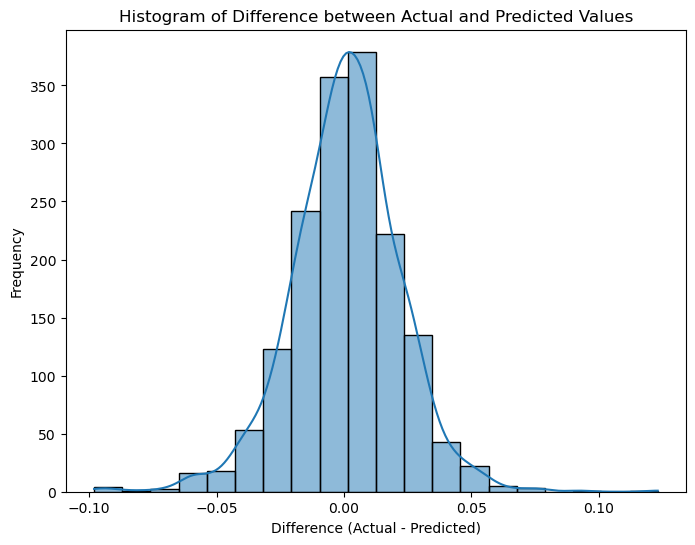

In [274]:
difference = ytest - y_predict
plt.figure(figsize=(8, 6))
sns.histplot(difference, bins=20, kde=True)
plt.xlabel('Difference (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between Actual and Predicted Values')
plt.show()

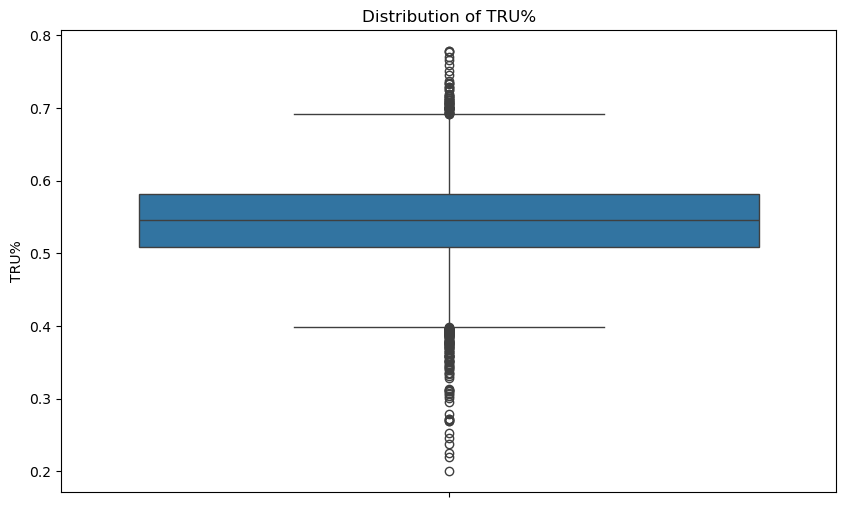

In [275]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='TRU%', data=data_per_player)
plt.ylabel('TRU%')
plt.title('Distribution of TRU%')
plt.show()

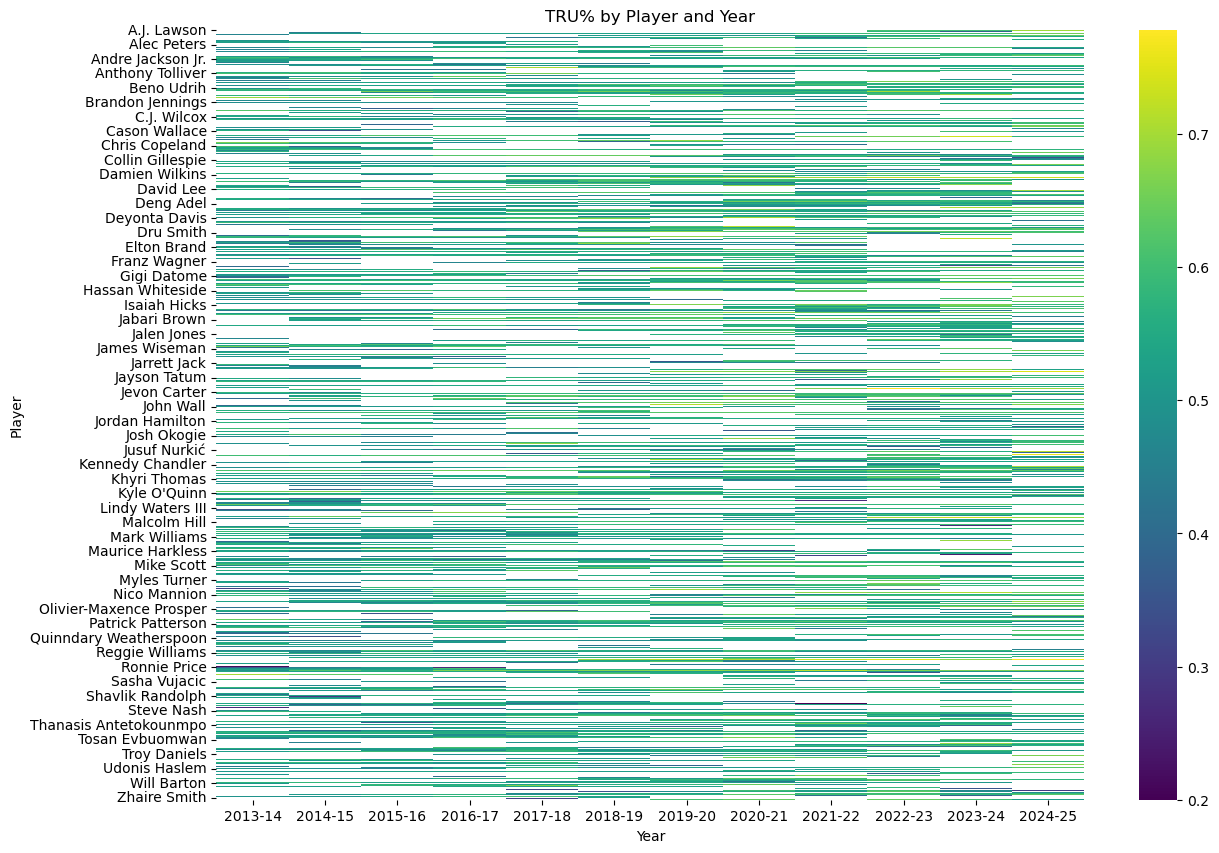

In [276]:
plt.figure(figsize=(14, 10))
sns.heatmap(data_per_player.pivot_table(index='PLAYER', columns='Year', values='TRU%'), cmap='viridis')
plt.xlabel('Year')
plt.ylabel('Player')
plt.title('TRU% by Player and Year')
plt.show()

In [277]:
# Create dropdown widget for player selection
player_dropdown = widgets.Dropdown(
    options=data_per_player['PLAYER'].unique(),
    description='Select Player:'
)

# Define function to predict TRU% for next year for selected player
def predict_next_year_tru_percentage(selected_player):
    # Subset data for the selected player
    player_data = data_per_player[data_per_player['PLAYER'] == selected_player]
    
    # Extract features for the last available year
    last_year_data = player_data.iloc[-1]  # Assuming the last row is the latest year
    features = last_year_data[['PTS/FGA', 'FG%', 'FGM', 'PTS']].values.reshape(1, -1)  # Reshaping for prediction
    
    # Use the model to predict TRU% for the next year
    next_year_tru_percentage = model.predict(dtotal)
    
    if isinstance(next_year_tru_percentage, np.ndarray):
        if next_year_tru_percentage.shape[0] == 1:
            next_year_tru_percentage = next_year_tru_percentage.item()  # Extract scalar value if it's a single prediction
        else:
            # If multiple predictions are returned, you can handle them accordingly
            print("Multiple predictions returned. Choose an appropriate approach.")
            next_year_tru_percentage = next_year_tru_percentage[0]
    
    # Print predicted TRU% for the next year
    print(f'Predicted TRU% for next year for {selected_player}: {next_year_tru_percentage:.2f}')
    
    # Provide evaluation based on TRU% prediction
    if next_year_tru_percentage > 0.65:
        print("Exceptional player with scoring efficiency")
    elif next_year_tru_percentage > 0.6:
        print("Good shooting efficiency") 
    elif next_year_tru_percentage > 0.55:
        print("Above average shooter")
    elif next_year_tru_percentage > 0.5:
        print("Average shooting efficiency")
    else:
        print("Below average shooting efficiency")

# Connect dropdown widget to the function
output = widgets.interactive_output(predict_next_year_tru_percentage, {'selected_player': player_dropdown})

# Display both the dropdown widget and the output
display(player_dropdown, output)


Dropdown(description='Select Player:', options=('A.J. Lawson', 'AJ Green', 'AJ Griffin', 'AJ Hammons', 'AJ Pri…

Output()

In [411]:
tot_cols_req =['GP','MIN','FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF','PTS']

In [413]:
def group_by_season(columns):
    data_season = data.groupby(['PLAYER','PLAYER_ID','Season'])[columns].sum().reset_index()
    return data_season

In [415]:
data_season=group_by_playerID(tot_cols_req)
data_season.head()

,PLAYER,PLAYER_ID,Year,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Lawson,1630639,2022-23,15.0,108.0,22.0,44.0,0.500,10.0,25.0,0.400,2.0,8.0,0.250,6.0,15.0,21,2.0,2.0,0.0,3.0,11.0,56.0
1,A.J. Lawson,1630639,2023-24,52.0,341.0,58.0,130.0,0.890,15.0,56.0,0.593,16.0,25.0,1.152,15.0,38.0,53,20.0,10.0,4.0,14.0,23.0,147.0
2,AJ Green,1631260,2022-23,35.0,345.0,53.0,125.0,0.424,44.0,105.0,0.419,4.0,4.0,1.000,6.0,39.0,45,22.0,6.0,0.0,9.0,31.0,154.0
3,AJ Green,1631260,2023-24,62.0,681.0,89.0,212.0,0.798,71.0,180.0,0.590,20.0,22.0,1.895,9.0,64.0,73,32.0,9.0,4.0,13.0,58.0,269.0
4,AJ Green,1631260,2024-25,24.0,507.0,65.0,136.0,0.478,59.0,124.0,0.476,5.0,6.0,0.833,4.0,47.0,51,23.0,12.0,2.0,17.0,51.0,194.0


In [417]:
data_season.shape

(6300, 23)

In [419]:
data_season['AST_TOV']=data_season['AST']/data_season['TOV']
data_season['STL_TOV']=data_season['STL']/data_season['TOV']
data_season['Efficiency'] = (data_season['PTS'] + data_season['REB'] + data_season['AST'] +data_season['STL'] + data_season['BLK'] - data_season['TOV']) / data_season['GP']

data_season

,PLAYER,PLAYER_ID,Year,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,AST_TOV,STL_TOV,Efficiency
0,A.J. Lawson,1630639,2022-23,15.0,108.0,22.0,44.0,0.500,10.0,25.0,0.400,2.0,8.0,0.250,6.0,15.0,21,2.0,2.0,0.0,3.0,11.0,56.0,0.666667,0.666667,5.2
1,A.J. Lawson,1630639,2023-24,52.0,341.0,58.0,130.0,0.890,15.0,56.0,0.593,16.0,25.0,1.152,15.0,38.0,53,20.0,10.0,4.0,14.0,23.0,147.0,1.428571,0.714286,4.230769
2,AJ Green,1631260,2022-23,35.0,345.0,53.0,125.0,0.424,44.0,105.0,0.419,4.0,4.0,1.000,6.0,39.0,45,22.0,6.0,0.0,9.0,31.0,154.0,2.444444,0.666667,6.228571
3,AJ Green,1631260,2023-24,62.0,681.0,89.0,212.0,0.798,71.0,180.0,0.590,20.0,22.0,1.895,9.0,64.0,73,32.0,9.0,4.0,13.0,58.0,269.0,2.461538,0.692308,6.032258
4,AJ Green,1631260,2024-25,24.0,507.0,65.0,136.0,0.478,59.0,124.0,0.476,5.0,6.0,0.833,4.0,47.0,51,23.0,12.0,2.0,17.0,51.0,194.0,1.352941,0.705882,11.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,Zion Williamson,1629627,2023-24,70.0,2207.0,624.0,1094.0,0.570,6.0,18.0,0.333,347.0,494.0,0.702,122.0,284.0,406,352.0,77.0,47.0,193.0,159.0,1601.0,1.823834,0.398964,32.714286
6296,Zion Williamson,1629627,2024-25,6.0,186.0,47.0,104.0,0.452,2.0,6.0,0.333,40.0,60.0,0.667,16.0,32.0,48,32.0,4.0,7.0,22.0,18.0,136.0,1.454545,0.181818,34.166667
6297,Zoran Dragic,204054,2014-15,16.0,75.0,11.0,30.0,0.367,3.0,14.0,0.214,3.0,5.0,0.600,5.0,3.0,8,5.0,2.0,0.0,5.0,6.0,28.0,1.000000,0.400000,2.375
6298,Zylan Cheatham,1629597,2019-20,4.0,51.0,6.0,9.0,0.667,0.0,1.0,0.000,0.0,0.0,0.000,3.0,6.0,9,3.0,1.0,1.0,4.0,10.0,12.0,0.750000,0.250000,5.5


In [421]:
for col in data_season.columns[5:] :
    data_season[col] = data_season[col]/data_season['GP']

data_season

,PLAYER,PLAYER_ID,Year,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,AST_TOV,STL_TOV,Efficiency
0,A.J. Lawson,1630639,2022-23,15.0,108.0,1.466667,2.933333,0.033333,0.666667,1.666667,0.026667,0.133333,0.533333,0.016667,0.400000,1.000000,1.4,0.133333,0.133333,0.000000,0.200000,0.733333,3.733333,0.044444,0.044444,0.346667
1,A.J. Lawson,1630639,2023-24,52.0,341.0,1.115385,2.500000,0.017115,0.288462,1.076923,0.011404,0.307692,0.480769,0.022154,0.288462,0.730769,1.019231,0.384615,0.192308,0.076923,0.269231,0.442308,2.826923,0.027473,0.013736,0.081361
2,AJ Green,1631260,2022-23,35.0,345.0,1.514286,3.571429,0.012114,1.257143,3.000000,0.011971,0.114286,0.114286,0.028571,0.171429,1.114286,1.285714,0.628571,0.171429,0.000000,0.257143,0.885714,4.400000,0.069841,0.019048,0.177959
3,AJ Green,1631260,2023-24,62.0,681.0,1.435484,3.419355,0.012871,1.145161,2.903226,0.009516,0.322581,0.354839,0.030565,0.145161,1.032258,1.177419,0.516129,0.145161,0.064516,0.209677,0.935484,4.338710,0.039702,0.011166,0.097294
4,AJ Green,1631260,2024-25,24.0,507.0,2.708333,5.666667,0.019917,2.458333,5.166667,0.019833,0.208333,0.250000,0.034708,0.166667,1.958333,2.125,0.958333,0.500000,0.083333,0.708333,2.125000,8.083333,0.056373,0.029412,0.460069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,Zion Williamson,1629627,2023-24,70.0,2207.0,8.914286,15.628571,0.008143,0.085714,0.257143,0.004757,4.957143,7.057143,0.010029,1.742857,4.057143,5.8,5.028571,1.100000,0.671429,2.757143,2.271429,22.871429,0.026055,0.005699,0.467347
6296,Zion Williamson,1629627,2024-25,6.0,186.0,7.833333,17.333333,0.075333,0.333333,1.000000,0.055500,6.666667,10.000000,0.111167,2.666667,5.333333,8.0,5.333333,0.666667,1.166667,3.666667,3.000000,22.666667,0.242424,0.030303,5.694444
6297,Zoran Dragic,204054,2014-15,16.0,75.0,0.687500,1.875000,0.022937,0.187500,0.875000,0.013375,0.187500,0.312500,0.037500,0.312500,0.187500,0.5,0.312500,0.125000,0.000000,0.312500,0.375000,1.750000,0.062500,0.025000,0.148438
6298,Zylan Cheatham,1629597,2019-20,4.0,51.0,1.500000,2.250000,0.166750,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.750000,1.500000,2.25,0.750000,0.250000,0.250000,1.000000,2.500000,3.000000,0.187500,0.062500,1.375


In [423]:
data_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PLAYER      6300 non-null   object 
 1   PLAYER_ID   6300 non-null   int64  
 2   Year        6300 non-null   object 
 3   GP          6300 non-null   float64
 4   MIN         6300 non-null   float64
 5   FGM         6300 non-null   float64
 6   FGA         6300 non-null   float64
 7   FG_PCT      6300 non-null   float64
 8   FG3M        6300 non-null   float64
 9   FG3A        6300 non-null   float64
 10  FG3_PCT     6300 non-null   float64
 11  FTM         6300 non-null   float64
 12  FTA         6300 non-null   float64
 13  FT_PCT      6300 non-null   float64
 14  OREB        6300 non-null   float64
 15  DREB        6300 non-null   float64
 16  REB         6300 non-null   object 
 17  AST         6300 non-null   float64
 18  STL         6300 non-null   float64
 19  BLK         6300 non-null  

In [425]:
cols_to_convert=['REB','Efficiency']
convert_columns_to_float(data_season,cols_to_convert)

In [427]:
data_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PLAYER      6300 non-null   object 
 1   PLAYER_ID   6300 non-null   int64  
 2   Year        6300 non-null   object 
 3   GP          6300 non-null   float64
 4   MIN         6300 non-null   float64
 5   FGM         6300 non-null   float64
 6   FGA         6300 non-null   float64
 7   FG_PCT      6300 non-null   float64
 8   FG3M        6300 non-null   float64
 9   FG3A        6300 non-null   float64
 10  FG3_PCT     6300 non-null   float64
 11  FTM         6300 non-null   float64
 12  FTA         6300 non-null   float64
 13  FT_PCT      6300 non-null   float64
 14  OREB        6300 non-null   float64
 15  DREB        6300 non-null   float64
 16  REB         6300 non-null   float64
 17  AST         6300 non-null   float64
 18  STL         6300 non-null   float64
 19  BLK         6300 non-null  

In [429]:
data_season.describe(include ='all')

,PLAYER,PLAYER_ID,Year,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,AST_TOV,STL_TOV,Efficiency
count,6300,6.300000e+03,6300,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6171.000000,6137.000000,6300.000000
unique,1576,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Kevin Love,NaN,2021-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,12,NaN,606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.943199e+05,NaN,48.850159,1113.680476,3.115240,6.858765,0.026504,0.851430,2.432876,0.013984,1.348567,1.769447,0.031793,0.843500,2.662410,3.505910,1.885835,0.618278,0.388995,1.083538,1.659179,8.430477,inf,inf,0.474563
std,NaN,7.292661e+05,NaN,28.286383,902.670475,2.268307,4.746607,0.067239,0.827183,2.148531,0.040969,1.368374,1.689461,0.060348,0.765914,1.831022,2.447389,1.810839,0.419482,0.408910,0.817323,0.791801,6.291389,NaN,NaN,1.015686
min,NaN,7.080000e+02,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000
25%,NaN,2.024980e+05,NaN,23.000000,287.750000,1.395196,3.285714,0.008500,0.142857,0.658180,0.004500,0.444444,0.644444,0.012272,0.318676,1.333333,1.760237,0.655172,0.310259,0.121951,0.500000,1.089486,3.750000,0.019519,0.006724,0.171652
50%,NaN,2.040600e+05,NaN,53.000000,938.000000,2.561387,5.666667,0.011814,0.646700,2.000000,0.007469,0.918364,1.259767,0.018369,0.612093,2.300943,3.000000,1.280000,0.555556,0.269752,0.887640,1.681818,6.811655,0.030995,0.011224,0.259132
75%,NaN,1.629044e+06,NaN,73.000000,1827.000000,4.347704,9.421061,0.019936,1.315058,3.666667,0.011971,1.768395,2.353786,0.028555,1.130721,3.542429,4.633803,2.479908,0.861538,0.507753,1.447059,2.214286,11.649365,0.059524,0.022496,0.432887


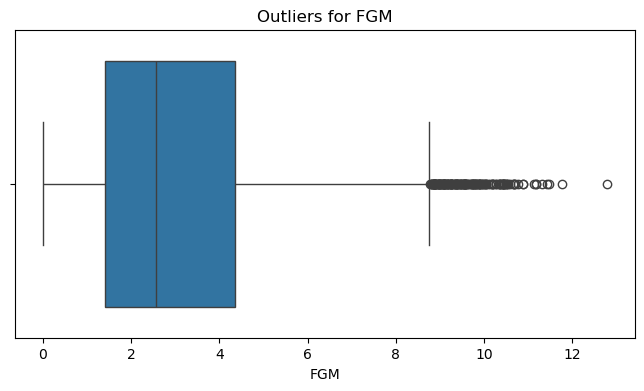

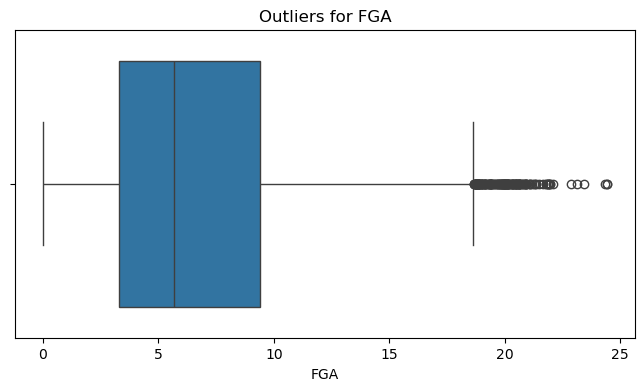

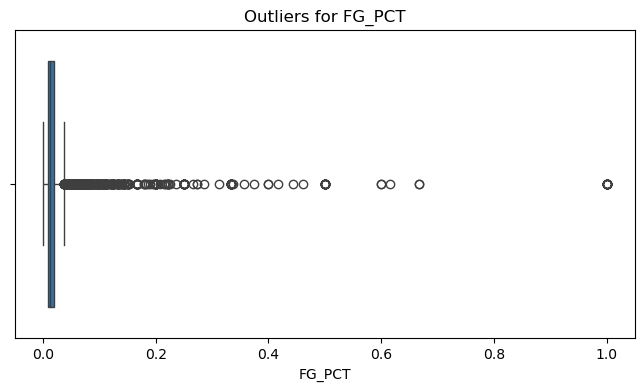

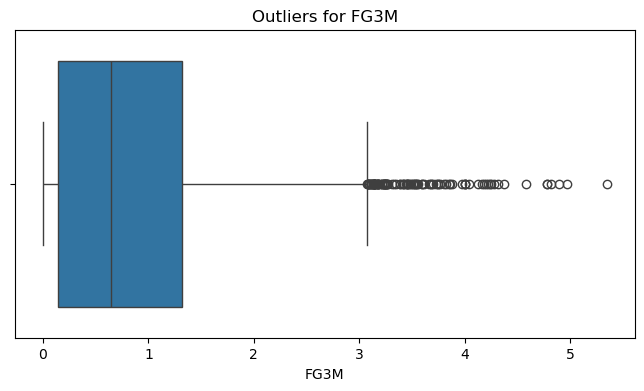

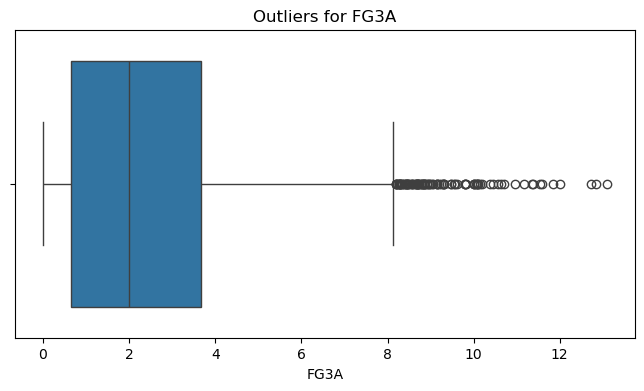

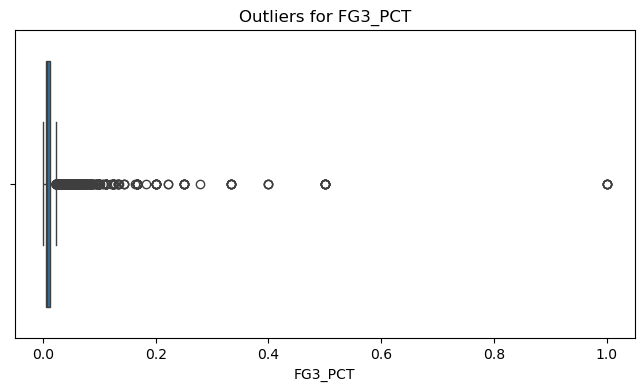

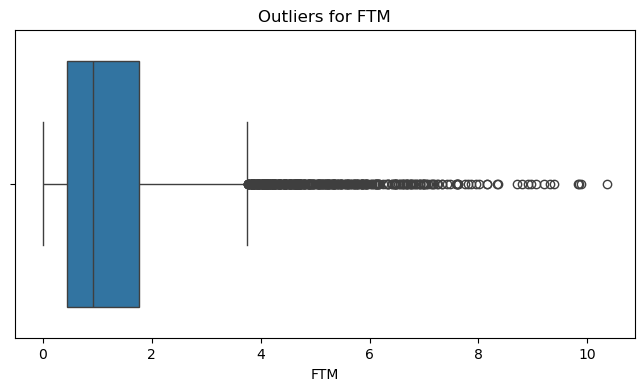

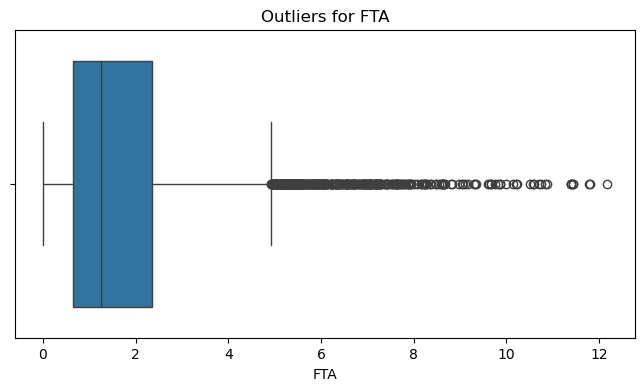

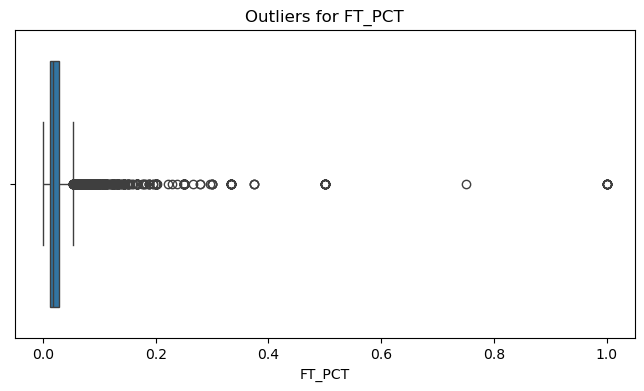

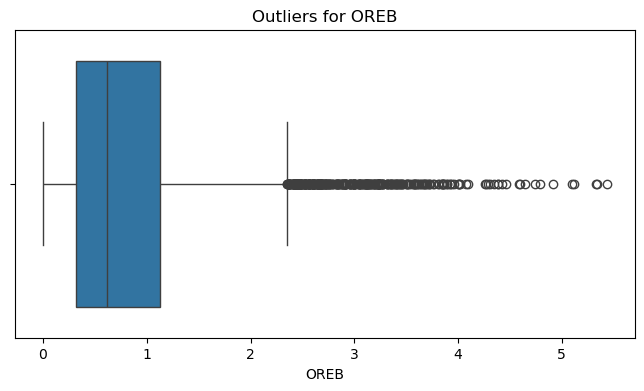

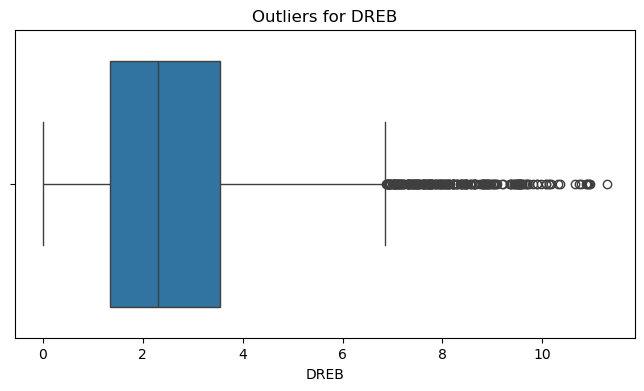

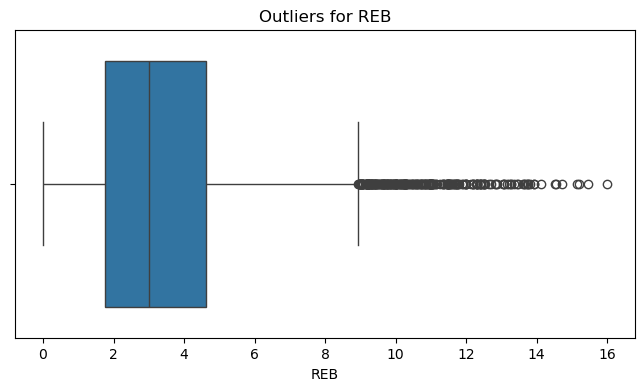

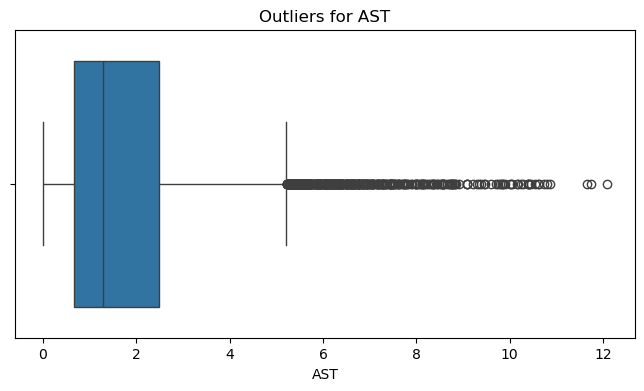

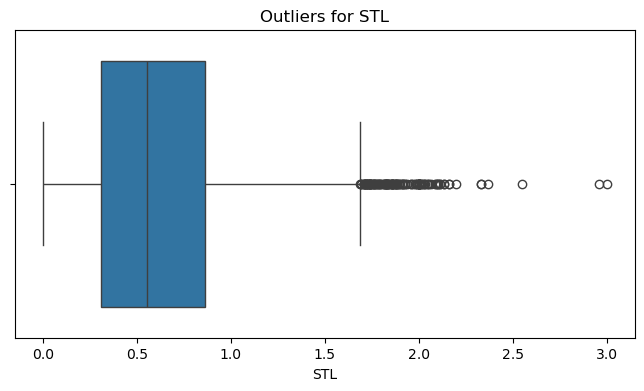

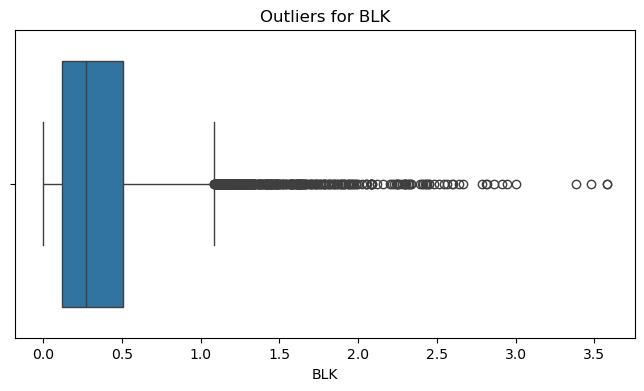

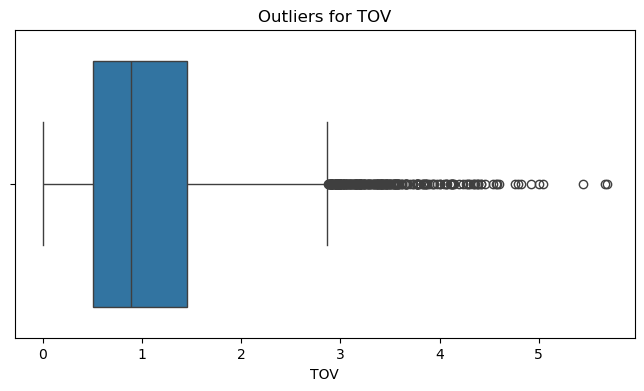

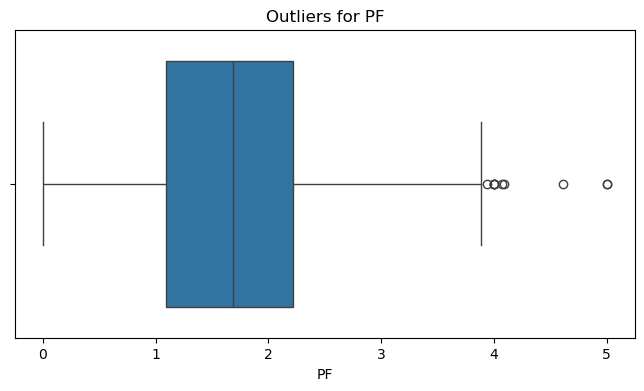

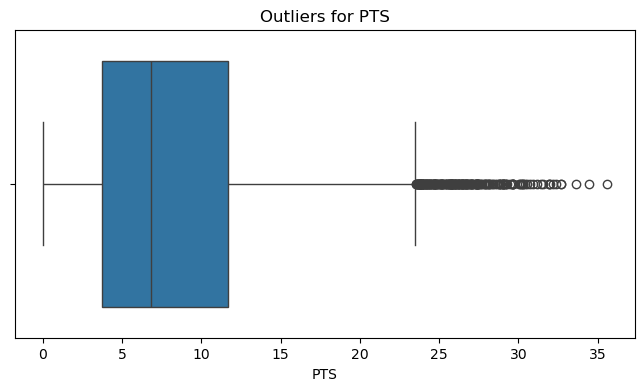

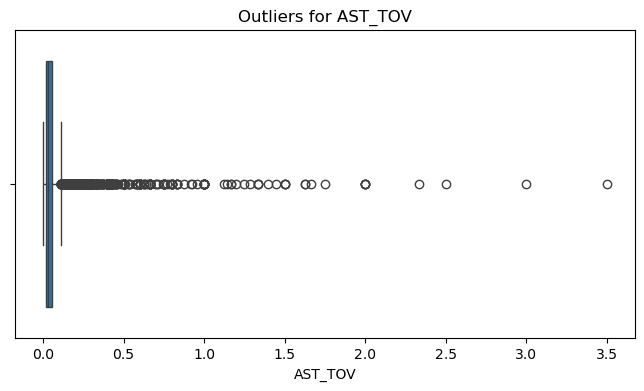

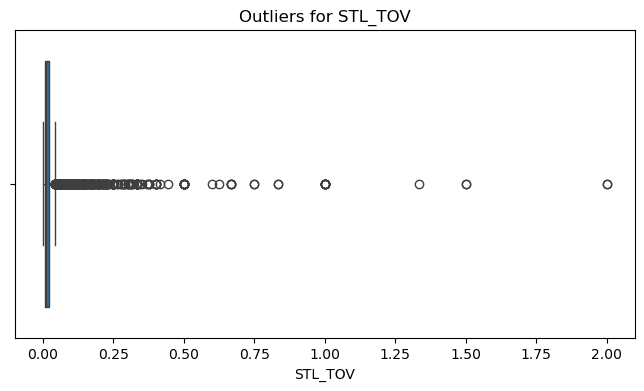

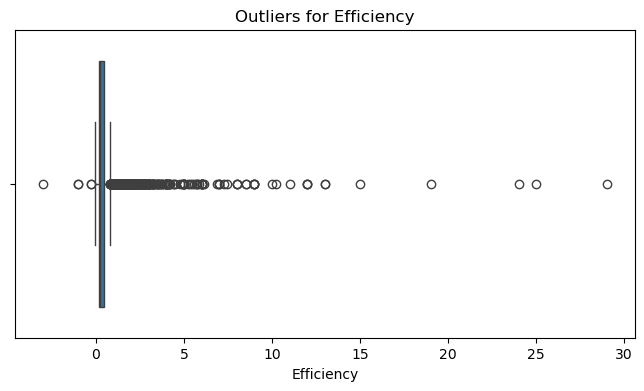

In [431]:
# plot boxplots
for col in data_season.columns[5:]:
    plt.figure(figsize=(8, 4))  # Optional: Adjust figure size for clarity
    sns.boxplot(data=data_season, x=col)  # Specify the data and column
    plt.title(f'Outliers for {col}')
    plt.show()

In [432]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)  
    IQR = Q3 - Q1                
    
  
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


for col in data_season.columns[5:]:
    if data_season[col].dtype in ['float64', 'int64']: 
        data_season = remove_outliers_iqr(data_season, col)


print("Outliers removed. Data preview:")
data_season.describe()

Outliers removed. Data preview:


,PLAYER_ID,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,AST_TOV,STL_TOV,Efficiency
count,2.696000e+03,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000
mean,8.167885e+05,62.810460,1252.682493,2.629898,5.931030,0.010700,0.852074,2.397595,0.006909,0.990138,1.313261,0.016930,0.726129,2.350727,3.076857,1.457402,0.557484,0.310341,0.883526,1.660860,7.102008,0.027607,0.011176,0.189555
std,7.268442e+05,18.637387,674.737783,1.231340,2.746979,0.004540,0.670121,1.727007,0.003824,0.613499,0.766083,0.006415,0.503266,1.050337,1.416687,0.937401,0.288809,0.221044,0.387513,0.574104,3.375967,0.013698,0.005435,0.069034
min,7.080000e+02,2.000000,8.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.076923,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.023250e+05,50.000000,714.500000,1.695652,3.819918,0.007389,0.307692,1.049128,0.004721,0.542196,0.745202,0.011896,0.339623,1.575201,2.000000,0.748941,0.337648,0.142857,0.590059,1.254170,4.542857,0.017719,0.007138,0.137458
50%,2.039030e+05,64.000000,1176.000000,2.460263,5.529321,0.009832,0.760563,2.260880,0.006687,0.857143,1.165423,0.016068,0.585540,2.200000,2.852273,1.227560,0.522064,0.255814,0.827042,1.651424,6.577035,0.025000,0.010163,0.181209
75%,1.628960e+06,77.000000,1743.000000,3.428571,7.621693,0.012552,1.273039,3.506396,0.009056,1.308754,1.740900,0.020513,1.000000,2.971514,4.000000,1.944697,0.738187,0.432836,1.135250,2.055556,9.272648,0.034439,0.014070,0.231550
max,1.641931e+06,104.000000,3354.000000,6.561644,14.761905,0.037909,3.012500,7.788235,0.019817,3.500000,4.253968,0.040000,2.454545,5.742857,7.563636,4.500000,1.441558,0.958333,2.047619,3.308824,16.775000,0.077381,0.028455,0.386831


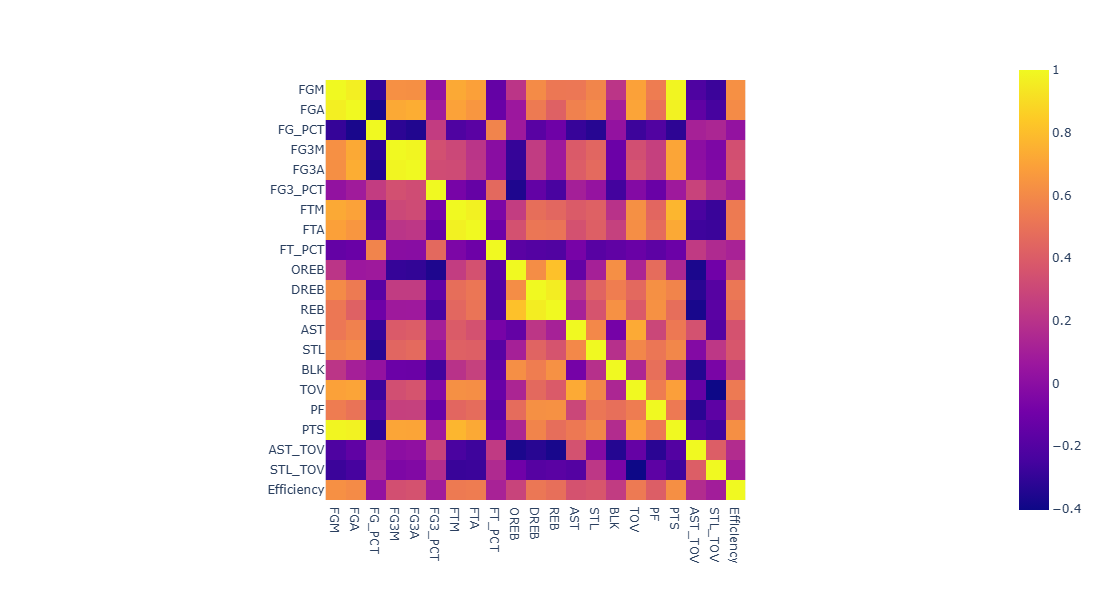

In [435]:
cols_for_correlation = ['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TOV','PF','PTS','AST_TOV','STL_TOV','Efficiency']
correlation=data_season[cols_for_correlation].corr()

fig = pex.imshow(correlation)
fig.update_layout(
    height=600,
    width=600    
)
fig.show()

In [437]:
correlation['PTS'].sort_values()

FG_PCT       -0.316487
STL_TOV      -0.263945
AST_TOV      -0.202626
FT_PCT       -0.114846
FG3_PCT       0.074479
OREB          0.141389
BLK           0.167349
REB           0.479487
AST           0.529793
PF            0.531116
DREB          0.578983
STL           0.588499
Efficiency    0.622988
TOV           0.686585
FG3A          0.708017
FG3M          0.711079
FTA           0.723346
FTM           0.770056
FGA           0.975593
FGM           0.985524
PTS           1.000000
Name: PTS, dtype: float64

In [441]:
Predictors_for_points=data_season[['REB','PF','AST','DREB','STL','TOV','Efficiency','FTA','FTM','FG3A','FG3M','FGA','FGM']]
target_points_per_game=data_season['PTS']

In [443]:
x_train,x_test,y_train,y_test=train_test_split(Predictors_for_points,target_points_per_game,test_size=0.3,random_state=42)

In [461]:
dpredictors=xgb.DMatrix(x_train,label=y_train)
dtarget=xgb.DMatrix(x_test,label=y_test)

In [465]:
hyper_parameter_tuning(Predictors_for_points,target_points_per_game,param_grid)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


In [467]:
model=training_model(learning_rate=0.1, max_depth=3,n_estimators=300, subsample=0.8,child_weight=5,training_matrix=dpredictors,testing_matrix=dtarget)
y_pred=model.predict(dtarget)
calculate_metrics(y_pred,y_test)

[0]	test-rmse:3.11921
[1]	test-rmse:2.82999
[2]	test-rmse:2.57333
[3]	test-rmse:2.34089
[4]	test-rmse:2.13246
[5]	test-rmse:1.94911
[6]	test-rmse:1.77933
[7]	test-rmse:1.62738
[8]	test-rmse:1.49317
[9]	test-rmse:1.36943
[10]	test-rmse:1.26109
[11]	test-rmse:1.16301
[12]	test-rmse:1.07492
[13]	test-rmse:0.99889
[14]	test-rmse:0.92630
[15]	test-rmse:0.86201
[16]	test-rmse:0.80057
[17]	test-rmse:0.75022
[18]	test-rmse:0.69662
[19]	test-rmse:0.64691
[20]	test-rmse:0.60993
[21]	test-rmse:0.57119


D:\Hima\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[17:01:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metrics", "n_estimators" } are not used.




[22]	test-rmse:0.53645
[23]	test-rmse:0.50548
[24]	test-rmse:0.47754
[25]	test-rmse:0.45338
[26]	test-rmse:0.43083
[27]	test-rmse:0.40744
[28]	test-rmse:0.38795
[29]	test-rmse:0.37172
[30]	test-rmse:0.35656
[31]	test-rmse:0.34181
[32]	test-rmse:0.32924
[33]	test-rmse:0.31765
[34]	test-rmse:0.30794
[35]	test-rmse:0.29940
[36]	test-rmse:0.29189
[37]	test-rmse:0.28469
[38]	test-rmse:0.27826
[39]	test-rmse:0.27216
[40]	test-rmse:0.26810
[41]	test-rmse:0.26401
[42]	test-rmse:0.25917
[43]	test-rmse:0.25508
[44]	test-rmse:0.25094
[45]	test-rmse:0.24804
[46]	test-rmse:0.24518
[47]	test-rmse:0.24333
[48]	test-rmse:0.24146
[49]	test-rmse:0.23909
[50]	test-rmse:0.23562
[51]	test-rmse:0.23323
[52]	test-rmse:0.23147
[53]	test-rmse:0.22903
[54]	test-rmse:0.22690
[55]	test-rmse:0.22603
[56]	test-rmse:0.22425
[57]	test-rmse:0.22306
[58]	test-rmse:0.22131
[59]	test-rmse:0.21993
[60]	test-rmse:0.21857
[61]	test-rmse:0.21729
[62]	test-rmse:0.21562
[63]	test-rmse:0.21442
[64]	test-rmse:0.21361
[65]	test-r

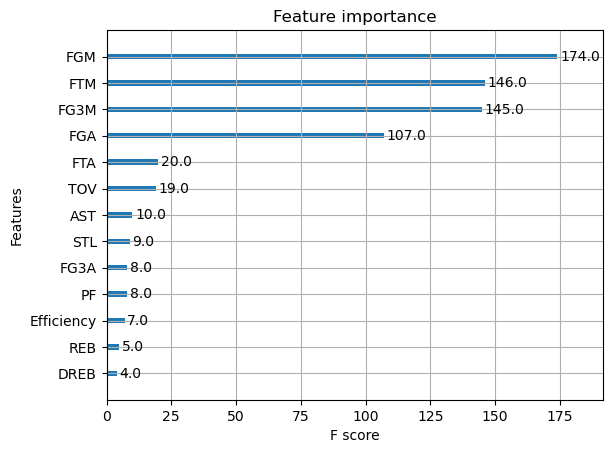

In [469]:
xgb.plot_importance(model)
plt.show()